## Predict outcome of football matches

Goal: To perform a multi-class prediction to determine if a match is won by the home team, away team or end in a draw. The data provided is an anonymised match data (match outcome and meta data) and data sports-betting odds from 30 book-keepers.

![picture](https://drive.google.com/uc?id=1ptgf_hab1CFdqbftm0sh1hT8cPnZ1DYs)

Kaggle competition: https://www.kaggle.com/competitions/up-data-practicum-ii-202122-football/data

### Extracting data from Kaggle API

*For information only. Please use the downloaded data set instead.* 


In [ ]:
# install dependencies and permission files to download Kaggle competition data

! pip install -q kaggle
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minerva79","key":"0d3f5d2f4b52a104d71fc5c5da8bd3fe"}'}

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list 

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25           3438        105  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           2907         84  1.0              
thedevastator/a-complete-history-of-nobel-prize-winners         Nobel Prize Winners                                   1MB  2022-10-08 00:09:57            680         24  1.0              
thedevastator/fast-food-restaurants-in-the-united-states    

In [ ]:
! kaggle competitions download -c 'up-data-practicum-ii-202122-football'

  0% 0.00/113k [00:00<?, ?B/s]
100% 113k/113k [00:00<00:00, 62.4MB/s]


In [ ]:
! mkdir data
! unzip /content/up-data-practicum-ii-202122-football.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  /content/up-data-practicum-ii-202122-football.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


### Data Exploration

Note:
* **id**: id of the match (unique)
* **season**: season in which the match has been played
* **stage**: stage of the match (1st week … last week of the season)
* **date**
* **home_team_api_id**: id of the home team
* **away_team_api_id**: id of the away team
* **home_team_goal**: goals scored by the home team
* **away_team_goal**: goals scored by the away team
* **B365H** … **BSA**: bookmakers coefficients for the home/away/match
* **outcome**: outcome of the match, which needs to be predicted (1 for a home team victory, 0 for a draw and -1 for the away team victory). This can be calculated from the home_team_goal and away_team_goal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Training data consisted of 2800 entries from 2008/2009 season to 2015/2016 season Stage 9.

Test data consisted of 240 entries in 2015/2016 season (stages 15 to 38)

#### Training data

In [2]:
train = pd.read_csv("train.csv")
train.head()

,id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,outcome
0,1729,2008/2009,1,2008-08-17 00:00:00,1,13,1,1,1.29,5.5,...,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00,0
1,1730,2008/2009,1,2008-08-16 00:00:00,2,16,1,0,1.20,6.5,...,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00,1
2,1731,2008/2009,1,2008-08-16 00:00:00,3,12,0,1,5.50,3.6,...,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73,-1
3,1732,2008/2009,1,2008-08-16 00:00:00,4,20,2,1,1.91,3.4,...,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80,1
4,1733,2008/2009,1,2008-08-17 00:00:00,5,18,4,2,1.91,3.4,...,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2800 non-null   int64  
 1   season            2800 non-null   object 
 2   stage             2800 non-null   int64  
 3   date              2800 non-null   object 
 4   home_team_api_id  2800 non-null   int64  
 5   away_team_api_id  2800 non-null   int64  
 6   home_team_goal    2800 non-null   int64  
 7   away_team_goal    2800 non-null   int64  
 8   B365H             2800 non-null   float64
 9   B365D             2800 non-null   float64
 10  B365A             2800 non-null   float64
 11  BWH               2800 non-null   float64
 12  BWD               2800 non-null   float64
 13  BWA               2800 non-null   float64
 14  IWH               2798 non-null   float64
 15  IWD               2798 non-null   float64
 16  IWA               2798 non-null   float64


In [ ]:
train.describe()

,id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,outcome
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,...,2800.000000,2800.000000,2800.000000,1899.000000,1899.000000,1899.000000,1900.000000,1900.000000,1900.000000,2800.000000
mean,3134.357143,18.900000,13.212143,13.177143,1.554286,1.158571,2.709279,3.958136,4.952271,2.609975,...,2.718243,3.962961,4.993717,2.606840,3.761980,4.566435,2.625553,3.773584,4.790621,0.173214
std,819.058671,11.042352,8.429265,8.427997,1.320104,1.144381,1.720569,1.011629,3.980764,1.556790,...,1.721107,1.024316,4.048439,1.586001,0.842088,3.301710,1.655792,0.837965,3.786069,0.845515
min,1729.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.100000,3.000000,1.220000,1.100000,...,1.090000,2.500000,1.220000,1.100000,3.000000,1.250000,1.100000,3.000000,1.220000,-1.000000
25%,2428.750000,9.000000,6.000000,6.000000,1.000000,0.000000,1.670000,3.300000,2.500000,1.620000,...,1.670000,3.300000,2.500000,1.650000,3.250000,2.450000,1.620000,3.250000,2.500000,-1.000000
50%,3128.500000,18.500000,12.000000,12.000000,1.000000,1.000000,2.200000,3.600000,3.500000,2.100000,...,2.200000,3.600000,3.600000,2.100000,3.400000,3.400000,2.100000,3.400000,3.400000,0.000000
75%,3828.250000,28.250000,19.000000,19.000000,2.000000,2.000000,2.912500,4.200000,5.500000,2.850000,...,3.000000,4.100000,5.500000,2.800000,3.900000,5.250000,2.800000,3.900000,5.500000,1.000000
max,4768.000000,38.000000,34.000000,34.000000,9.000000,6.000000,15.000000,11.000000,29.000000,12.500000,...,15.000000,10.000000,29.000000,12.000000,8.500000,21.000000,13.000000,8.500000,26.000000,1.000000


In [4]:
bookies = train.columns.values.tolist()[8:38]

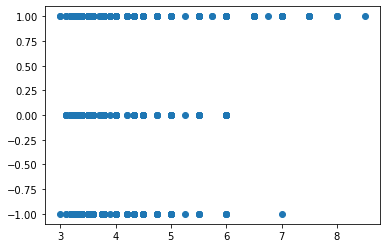

In [5]:
plt.scatter(train['BSD'], train['outcome'])

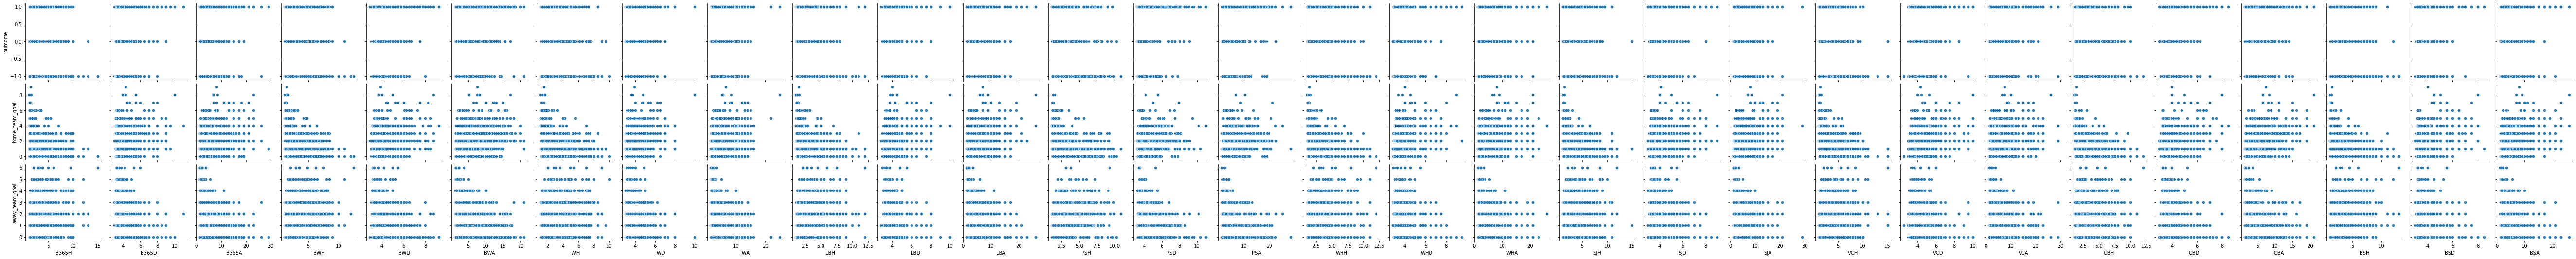

In [ ]:
sns.pairplot(
    train,
    x_vars=bookies,
    y_vars=["outcome", "home_team_goal", "away_team_goal"]
)

# note range of odds differ slight (i.e. centering of data likely needed)

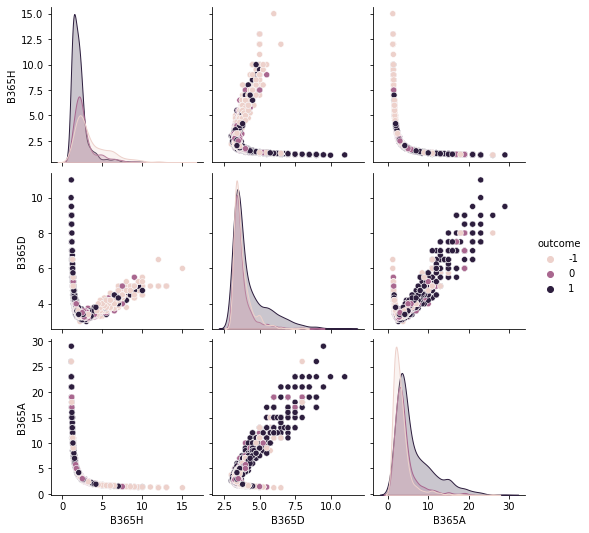

In [ ]:
sns.pairplot(
    train,
    x_vars=["B365H", "B365D", "B365A"],
    y_vars=["B365H", "B365D", "B365A"],
    hue="outcome"
)
# note: while bookies with suffixes "H", "D" and "A" are not mutually-exclusive, they do infer that the bigger the odds for home, draw and away teams.
# 
# bookies implicitly favour home team. So odds for betting for home-win (suffix "H") tend to be lower than win (suffix "A")
# i.e. each book serves it's purpose, despite slight correlation; keep for now.

Missing values...

In [ ]:
train.isnull().sum()/train.shape[0]

# missingness:
  # 54.3% PSH PSD PSA 
  # 32.2% GBH GBD GBA
  # 32.1% BSH BSD BSA
  # 17.1% SJH SJD SJA
  # < 1% IWH IWD IWA LBH LBD LBA

id                  0.000000
season              0.000000
stage               0.000000
date                0.000000
home_team_api_id    0.000000
away_team_api_id    0.000000
home_team_goal      0.000000
away_team_goal      0.000000
B365H               0.000000
B365D               0.000000
B365A               0.000000
BWH                 0.000000
BWD                 0.000000
BWA                 0.000000
IWH                 0.000714
IWD                 0.000714
IWA                 0.000714
LBH                 0.000357
LBD                 0.000357
LBA                 0.000357
PSH                 0.543214
PSD                 0.543214
PSA                 0.543214
WHH                 0.000000
WHD                 0.000000
WHA                 0.000000
SJH                 0.171429
SJD                 0.171429
SJA                 0.171429
VCH                 0.000000
VCD                 0.000000
VCA                 0.000000
GBH                 0.321786
GBD                 0.321786
GBA           

#### Test Data

In [6]:
test = pd.read_csv("test.csv")
test.head()

,id,season,stage,date,home_team_api_id,away_team_api_id,B365H,B365D,B365A,BWH,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,4449,2015/2016,15,2015-12-05 00:00:00,2,3,1.29,6.00,13.00,1.26,...,NaN,1.29,5.75,13.00,NaN,NaN,NaN,NaN,NaN,NaN
1,4450,2015/2016,15,2015-12-05 00:00:00,10,33,1.36,5.25,9.50,1.38,...,NaN,1.36,5.25,10.00,NaN,NaN,NaN,NaN,NaN,NaN
2,4451,2015/2016,15,2015-12-07 00:00:00,6,30,2.10,3.60,3.75,2.10,...,NaN,2.05,3.60,3.80,NaN,NaN,NaN,NaN,NaN,NaN
3,4452,2015/2016,15,2015-12-05 00:00:00,1,4,1.44,4.50,9.00,1.44,...,NaN,1.44,4.50,9.00,NaN,NaN,NaN,NaN,NaN,NaN
4,4453,2015/2016,15,2015-12-06 00:00:00,13,12,5.75,4.33,1.62,5.50,...,NaN,6.00,4.20,1.62,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                240 non-null    int64  
 1   season            240 non-null    object 
 2   stage             240 non-null    int64  
 3   date              240 non-null    object 
 4   home_team_api_id  240 non-null    int64  
 5   away_team_api_id  240 non-null    int64  
 6   B365H             240 non-null    float64
 7   B365D             240 non-null    float64
 8   B365A             240 non-null    float64
 9   BWH               239 non-null    float64
 10  BWD               239 non-null    float64
 11  BWA               239 non-null    float64
 12  IWH               240 non-null    float64
 13  IWD               240 non-null    float64
 14  IWA               240 non-null    float64
 15  LBH               240 non-null    float64
 16  LBD               240 non-null    float64
 1

In [ ]:
test.isnull().sum()/test.shape[0]


# missingness:
  # 100% SJH SJD SJA GBH GBD GBA BSH BSD BSA
  # <1% BWH BWD BWA

id                  0.000000
season              0.000000
stage               0.000000
date                0.000000
home_team_api_id    0.000000
away_team_api_id    0.000000
B365H               0.000000
B365D               0.000000
B365A               0.000000
BWH                 0.004167
BWD                 0.004167
BWA                 0.004167
IWH                 0.000000
IWD                 0.000000
IWA                 0.000000
LBH                 0.000000
LBD                 0.000000
LBA                 0.000000
PSH                 0.000000
PSD                 0.000000
PSA                 0.000000
WHH                 0.000000
WHD                 0.000000
WHA                 0.000000
SJH                 1.000000
SJD                 1.000000
SJA                 1.000000
VCH                 0.000000
VCD                 0.000000
VCA                 0.000000
GBH                 1.000000
GBD                 1.000000
GBA                 1.000000
BSH                 1.000000
BSD           

### Feature Engineering

#### Extract day of week

In [7]:
import datetime as dt
# convert date to datetime 
train.date = pd.to_datetime(train.date)
# extract day of week and store as new variable
train["dayofweek"] = train.date.dt.dayofweek # Monday(1) .. Sunday(6)
train

,id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,outcome,dayofweek
0,1729,2008/2009,1,2008-08-17,1,13,1,1,1.29,5.5,...,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00,0,6
1,1730,2008/2009,1,2008-08-16,2,16,1,0,1.20,6.5,...,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00,1,5
2,1731,2008/2009,1,2008-08-16,3,12,0,1,5.50,3.6,...,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73,-1,5
3,1732,2008/2009,1,2008-08-16,4,20,2,1,1.91,3.4,...,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80,1,5
4,1733,2008/2009,1,2008-08-17,5,18,4,2,1.91,3.4,...,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,4764,2015/2016,9,2015-10-17,29,32,2,2,1.75,4.0,...,3.9,5.00,NaN,NaN,NaN,NaN,NaN,NaN,0,5
2796,4765,2015/2016,9,2015-10-19,27,11,0,1,2.05,3.4,...,3.4,4.10,NaN,NaN,NaN,NaN,NaN,NaN,-1,0
2797,4766,2015/2016,9,2015-10-17,15,12,0,0,2.50,3.5,...,3.5,3.00,NaN,NaN,NaN,NaN,NaN,NaN,0,5
2798,4767,2015/2016,9,2015-10-17,34,2,0,3,6.00,4.2,...,4.2,1.60,NaN,NaN,NaN,NaN,NaN,NaN,-1,5


In [8]:
# convert date to datetime 
test.date = pd.to_datetime(test.date)
# extract day of week and store as new variable
test["dayofweek"] = test.date.dt.dayofweek # Monday(1) .. Sunday(6)
test

,id,season,stage,date,home_team_api_id,away_team_api_id,B365H,B365D,B365A,BWH,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,dayofweek
0,4449,2015/2016,15,2015-12-05,2,3,1.29,6.00,13.00,1.26,...,1.29,5.75,13.00,NaN,NaN,NaN,NaN,NaN,NaN,5
1,4450,2015/2016,15,2015-12-05,10,33,1.36,5.25,9.50,1.38,...,1.36,5.25,10.00,NaN,NaN,NaN,NaN,NaN,NaN,5
2,4451,2015/2016,15,2015-12-07,6,30,2.10,3.60,3.75,2.10,...,2.05,3.60,3.80,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4452,2015/2016,15,2015-12-05,1,4,1.44,4.50,9.00,1.44,...,1.44,4.50,9.00,NaN,NaN,NaN,NaN,NaN,NaN,5
4,4453,2015/2016,15,2015-12-06,13,12,5.75,4.33,1.62,5.50,...,6.00,4.20,1.62,NaN,NaN,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,4704,2015/2016,38,2016-05-15,29,30,1.36,5.50,9.00,1.33,...,1.33,5.50,10.00,NaN,NaN,NaN,NaN,NaN,NaN,6
236,4705,2015/2016,38,2016-05-15,11,4,3.50,3.60,2.15,3.30,...,3.50,3.80,2.10,NaN,NaN,NaN,NaN,NaN,NaN,6
237,4706,2015/2016,38,2016-05-15,27,18,6.00,4.75,1.53,5.75,...,5.20,4.75,1.53,NaN,NaN,NaN,NaN,NaN,NaN,6
238,4707,2015/2016,38,2016-05-15,34,3,2.05,3.75,3.70,2.05,...,2.05,3.75,3.70,NaN,NaN,NaN,NaN,NaN,NaN,6


#### Extract month

In [9]:
# extract month from date and store as new variable
train["month"] = train.date.dt.month
test["month"] = test.date.dt.month

#### Convert Season, stage, home team id and away team id into string

In [10]:
# split season and retain the first year (e.g. season 2008/2009 retained as 2008)
train.season = train['season'].str.split('/', 1, expand=True)[:][0]
# convert season as string variable
train.stage = train['stage'].astype(str)
# convert home_team_api_id as string variable
train.home_team_api_id = train['home_team_api_id'].astype(str)
# convert away_team_api_id as string variable
train.away_team_api_id = train['away_team_api_id'].astype(str)

In [11]:
# split season and retain the first year (e.g. season 2008/2009 retained as 2008)
test.season = test['season'].str.split('/', 1, expand=True)[:][0]
# convert season as string variable
test.stage = test['stage'].astype(str)
# convert home_team_api_id as string variable
test.home_team_api_id = test['home_team_api_id'].astype(str)
# convert away_team_api_id as string variable
test.away_team_api_id = test['away_team_api_id'].astype(str)

#### Convert outcome to string

In [12]:
# convert season as string variable
train.stage = train['outcome'].astype(str)

#### Feature Creation - Average number of goals for season

In [13]:
# create aggregate table for average goals for home team by season and home team id
home_team_goal_average = train.\
    groupby(['season', 'home_team_api_id'])['home_team_goal'].\
    mean().\
    reset_index(name='home_team_goal_average')

# create aggregate table for average goals for away team by season and away team id
away_team_goal_average = train.\
    groupby(['season', 'away_team_api_id'])['away_team_goal'].\
    mean().\
    reset_index(name='away_team_goal_average')

print(home_team_goal_average)
print(away_team_goal_average)


    season home_team_api_id  home_team_goal_average
0     2008                1                2.263158
1     2008               10                1.736842
2     2008               11                1.157895
3     2008               12                2.157895
4     2008               13                1.263158
..     ...              ...                     ...
155   2015               33                1.142857
156   2015               34                0.571429
157   2015                4                1.714286
158   2015                5                0.714286
159   2015                6                2.285714

[160 rows x 3 columns]
    season away_team_api_id  away_team_goal_average
0     2008                1                1.315789
1     2008               10                1.842105
2     2008               11                0.842105
3     2008               12                1.894737
4     2008               13                0.842105
..     ...              ...             

In [14]:
# left_join train data with aggregated home goal average data
train = train.merge(home_team_goal_average,
                    on=['season', 'home_team_api_id'],
                    how='left')
# left_join train data with aggregated away goal average data
train = train.merge(away_team_goal_average,
                    on=['season', 'away_team_api_id'],
                    how='left')
# left_join test data with aggregated home goal average data
test = test.merge(home_team_goal_average,
                  on=['season', 'home_team_api_id'],
                  how='left')
# left_join test data with aggregated away goal average data
test = test.merge(away_team_goal_average,
                  on=['season', 'away_team_api_id'],
                  how='left')

#### Handling missing values




#### Missing values for test data 

* Remove SJH SJD SJA GBH GBD GBA BSH BSD BSA from both training and test data
  - Reason: these 9 attributes are totally missing from test data

In [15]:
# list of variables to drop
dropped_columns = ['SJH', 'SJD', 'SJA',
                   'GBH', 'GBD', 'GBA',
                   'BSH', 'BSD', 'BSA']
# drop listed variables from training data
train = train.drop(dropped_columns, axis=1)
# drop listed variables from test data
test = test.drop(dropped_columns, axis=1)



*   Impute missing values of BWH BWD BWA in test data with mean
  -  1 entry of BWH BWD BWA missing from test data



In [16]:
# fill missing value with average
test = test.fillna(test.mean())

C:\Users\kelly\AppData\Local\Temp\ipykernel_11628\1453853768.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test = test.fillna(test.mean())


#### Missing values for training set

  * Impute IWH IWD IWA LBH LBD LBA with mean
    -    Less than 1% of data missing  

In [17]:
# create list of variables to fill with missing
impute_with_mean_var = ['IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA']
# fill missing value with average
train.loc[:, impute_with_mean_var] = train.loc[:, impute_with_mean_var].fillna(train.mean()) 

C:\Users\kelly\AppData\Local\Temp\ipykernel_11628\3127469546.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train.loc[:, impute_with_mean_var] = train.loc[:, impute_with_mean_var].fillna(train.mean())
C:\Users\kelly\AppData\Local\Temp\ipykernel_11628\3127469546.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.loc[:, impute_with_mean_var] = train.loc[:, impute_with_mean_var].fillna(train.mean())



*   Drop PSH PSD and PSA
  - 54.3% of data missing from the three attributes

In [18]:
# list of variables to drop
dropped_columns = ['PSH', 'PSD', 'PSA']
# drop variables
train = train.drop(dropped_columns, axis=1)

#### Remove attributes not used for prediction in training data

* Remove id as we are not predicting for specific matches
* Remove date as it is not useful as a continuous variable 
  - date range of test data is after that of training data
  - season, stage, month and dayofweek as proxy measurements for time instead
* Remove outcome of matches (i.e. number of team goals and outcome)
  - goal averages as proxy measure for the teams

In [19]:
# list of variables to drop
dropped_columns = ['id', 'date', 'home_team_goal', 'away_team_goal']
#drop variables
train = train.drop(dropped_columns, axis=1)

### Feature Selection

In [20]:
# explore the number of selected features for RFE
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 27):
		rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i)
		model = RandomForestClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', 
                          cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [21]:
X_train = train.drop(['outcome'],axis=1)
y_train = train.outcome.values 

X_scaled =  StandardScaler().fit_transform(X_train) 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_scaled, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>2 1.000 (0.000)
>3 1.000 (0.000)
>4 1.000 (0.000)
>5 1.000 (0.000)
>6 1.000 (0.000)
>7 1.000 (0.000)
>8 1.000 (0.000)


KeyboardInterrupt: 

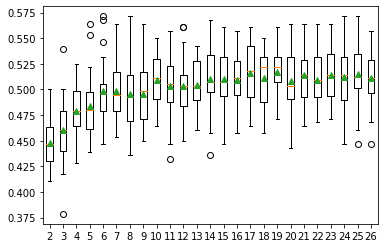

In [ ]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# define RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=19)
# fit RFE
rfe.fit(X_scaled, y_train)
# summarize all features
for i in range(X_scaled.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 6.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 3.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 2.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 5.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 7.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 4.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 8.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selected True, R

In [22]:
# selected variables
selected_variables = [1, 2, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 
                      18, 19, 20, 21, 23, 24, 25]
X_train_reduced = X_train.iloc[:, selected_variables]
print(X_train_reduced)

     stage home_team_api_id away_team_api_id  B365H  B365A   BWH    BWA   IWH  \
0        0                1               13   1.29  11.00  1.30   8.25  1.30   
1        1                2               16   1.20  15.00  1.22  10.00  1.20   
2       -1                3               12   5.50   1.67  5.00   1.67  4.50   
3        1                4               20   1.91   4.20  1.90   3.80  1.80   
4        1                5               18   1.91   4.33  1.95   3.60  2.00   
...    ...              ...              ...    ...    ...   ...    ...   ...   
2795     0               29               32   1.75   5.00  1.75   4.40  1.80   
2796    -1               27               11   2.05   4.20  2.05   3.75  2.00   
2797     0               15               12   2.50   3.00  2.50   2.95  2.50   
2798    -1               34                2   6.00   1.62  5.00   1.60  5.00   
2799     1               16                3   2.05   4.20  2.05   3.60  1.85   

        IWA   LBH    LBA   

### Modelling + Grid Search

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_train_reduced, y_train, test_size=0.33, random_state=4)


classifier = RandomForestClassifier()
classifier.fit(X_train_2, y_train_2)

RandomForestClassifier()

In [ ]:
importances = classifier.feature_importances_
columns = X_train_2.columns
i = 0

while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(importances[i]*100, 2)} %.")
    i+=1

The importance of feature stage is 70.67 %.
The importance of feature home_team_api_id is 1.42 %.
The importance of feature away_team_api_id is 1.36 %.
The importance of feature B365H is 1.5 %.
The importance of feature B365A is 1.26 %.
The importance of feature BWH is 1.87 %.
The importance of feature BWA is 2.02 %.
The importance of feature IWH is 2.17 %.
The importance of feature IWA is 2.22 %.
The importance of feature LBH is 1.49 %.
The importance of feature LBA is 1.36 %.
The importance of feature WHH is 1.41 %.
The importance of feature WHA is 1.68 %.
The importance of feature VCH is 1.79 %.
The importance of feature VCD is 1.11 %.
The importance of feature VCA is 1.47 %.
The importance of feature month is 1.23 %.
The importance of feature home_team_goal_average is 2.14 %.
The importance of feature away_team_goal_average is 1.82 %.


In [ ]:
classifier.predict_proba(X_valid_2)

array([[0.89, 0.08, 0.03],
       [0.88, 0.05, 0.07],
       [0.08, 0.9 , 0.02],
       ...,
       [0.96, 0.04, 0.  ],
       [0.91, 0.07, 0.02],
       [0.08, 0.9 , 0.02]])

In [24]:
# Use the forest's predict method on the validation data
y_pred = classifier.predict(X_valid_2)# Calculate the absolute errors
confusion_matrix(y_valid_2, y_pred)

array([[275,   0,   0],
       [  0, 235,   0],
       [  0,   0, 414]], dtype=int64)

Grid search

In [25]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2,3,4,5],
    #'criterion' :['absolute_error','squared_error'],
    'n_estimators': [5,10,20,30, 40,50,60,70,80,100,150,200]
}
# Create a base model
model = RandomForestClassifier(random_state = 4)

# Instantiate the grid search model
regCV = GridSearchCV(estimator = model, cv=5,param_grid = param_grid, n_jobs = -1, verbose = 2, return_train_score=True)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


In [26]:
# Fit the grid search to the data
regCV.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [5, 10, 20, 30, 40, 50, 60, 70, 80,
                                          100, 150, 200]},
             return_train_score=True, verbose=2)

In [27]:
evaluate(regCV, X_valid_2, y_valid_2)

Model Performance
Average Error: 0.0043 degrees.
Accuracy = nan%.


C:\Users\kelly\AppData\Local\Temp\ipykernel_11628\2798519231.py:17: RuntimeWarning: invalid value encountered in true_divide
  mape = 100 * np.mean(errors / test_labels)


nan

In [28]:
y_pred = regCV.predict(X_valid_2)
confusion_matrix(y_valid_2, y_pred)

array([[273,   0,   2],
       [  0, 235,   0],
       [  0,   0, 414]], dtype=int64)

In [29]:
selected_var = X_train_2.columns.values.tolist()
X_test = test.loc[:, selected_var]
y_pred = regCV.predict(X_test)

In [33]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [32]:
y_pd = pd.DataFrame(y_pred)

,0
0,1
1,1
2,1
3,1
4,1
...,...
235,1
236,1
237,1
238,1
